In [ ]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold,KFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import zscore
import datetime
from sklearn.metrics import fbeta_score, make_scorer,recall_score
!pip install catboost

from catboost import CatBoostClassifier

In [ ]:
def additional_info(df):
    print("\n",'*** Shape:',df.shape)
    print("\n",'*** Data:',df.head(10))
    print("\n","*** Columns:", df.columns)
    print("\n",'*** Info:')
    df.info()
    print("\n",'*** Missing values:')
    print(df.isnull().sum())
    print("\n",'*** Data Statistics:')
    print(df.describe(include='all'))

# All_training Dataset

In [ ]:
train = pd.read_csv("trainingimp.csv")
additional_info(train)


 *** Shape: (1736, 16)

 *** Data:    Patient Id  Alanine Aminotransferase (ALT)  \
0         687                        0.172216   
1         642                       -0.027617   
2        1184                        0.489598   
3         888                       -0.286225   
4         222                        0.042912   
5         796                       -0.540915   
6        1129                       -0.474303   
7         553                       -0.591852   
8         619                       -0.160840   
9        1418                       -0.474303   

   Aspartate Aminotransferase (AST)  C-Reactive Protein (CRP)  \
0                          1.147796                 -0.217913   
1                         -0.036604                 -0.352279   
2                          1.068836                 -0.538720   
3                         -0.234005                  1.594425   
4                          0.437156                  0.267478   
5                         -0.32941

In [ ]:
columns = ['Patient Id', 'Alanine Aminotransferase (ALT)', 'Aspartate Aminotransferase (AST)', 'C-Reactive Protein (CRP)', 'Lactate Dehydrogenase (LDH)','White Blood cell Count (Leukocytes)', 'Lymphocyte Count','Neutrophil Count','Age','Platelets','Basophils','Eosinophils','Monocyte','Alkaline Phosphatase (ALP)','Gamma-glutamyltransferase (GGT)','Class']
train = train.set_axis(columns, axis=1)
train.columns

Index(['Patient Id', 'Alanine Aminotransferase (ALT)',
       'Aspartate Aminotransferase (AST)', 'C-Reactive Protein (CRP)',
       'Lactate Dehydrogenase (LDH)', 'White Blood cell Count (Leukocytes)',
       'Lymphocyte Count', 'Neutrophil Count', 'Age', 'Platelets', 'Basophils',
       'Eosinophils', 'Monocyte', 'Alkaline Phosphatase (ALP)',
       'Gamma-glutamyltransferase (GGT)', 'Class'],
      dtype='object')

In [ ]:
train['Class'].value_counts()

0    920
1    816
Name: Class, dtype: int64

816 Positive Patients
920 Negative Patients

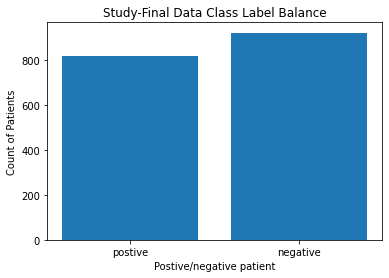

In [ ]:
count_neg = train.Class[train['Class'] == 0].size
count_pos = train.Class[train['Class'] == 1].size

plt.bar(['postive', 'negative'], [count_pos, count_neg])
plt.title('Study-Final Data Class Label Balance')
plt.xlabel('Postive/negative patient')
plt.ylabel('Count of Patients')
plt.show()

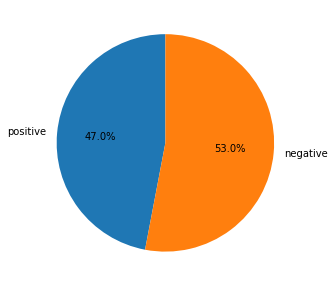

In [ ]:
labels = ['positive', 'negative']
sizes = [count_pos, count_neg]
fig1, ax1 = plt.subplots(1,1, figsize=(5,5))
wedges, text, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

## Imputing Values

In [ ]:
#Simple Imputer
imputer = SimpleImputer(missing_values = np.NaN, strategy ='most_frequent')
imputer = imputer.fit(train)

# Imputing the data
train = imputer.transform(train)
train = pd.DataFrame(data=train, columns=columns)
train.head(10)

,Patient Id,Alanine Aminotransferase (ALT),Aspartate Aminotransferase (AST),C-Reactive Protein (CRP),Lactate Dehydrogenase (LDH),White Blood cell Count (Leukocytes),Lymphocyte Count,Neutrophil Count,Age,Platelets,Basophils,Eosinophils,Monocyte,Alkaline Phosphatase (ALP),Gamma-glutamyltransferase (GGT),Class
0,687.0,0.172216,1.147796,-0.217913,0.332596,-0.641669,-0.333062,-0.480785,75.0,-1.573068,-0.410494,-0.464671,-0.503528,0.559584,0.988496,1.0
1,642.0,-0.027617,-0.036604,-0.352279,0.772220,-0.307209,-0.280534,-0.190222,56.0,-0.049501,-0.410494,-0.464671,-0.041122,-0.049550,-0.156768,1.0
2,1184.0,0.489598,1.068836,-0.538720,-0.125937,1.160099,-0.700760,-0.480785,77.0,-0.325548,-0.410494,-0.464671,-0.411047,-0.413630,-0.186323,0.0
3,888.0,-0.286225,-0.234005,1.594425,-0.390657,1.677972,-0.175477,1.664912,73.0,-0.219376,2.111349,-0.464671,1.253617,-0.217587,-0.245433,0.0
4,222.0,0.042912,0.437156,0.267478,1.315841,-0.825083,-0.700760,-0.547838,69.0,-0.962579,-0.410494,-0.464671,-0.596010,0.006462,-0.023769,1.0
5,796.0,-0.540915,-0.329415,0.993956,-0.471018,-0.317382,0.169709,-0.279626,85.0,-0.765403,-0.050231,0.229468,-0.392551,-0.413630,-0.404292,1.0
6,1129.0,-0.474303,-0.312965,-0.858885,-0.697921,-0.522990,0.664975,-0.637242,77.0,-0.867025,-0.410494,-0.464671,0.143841,-0.357618,-0.400598,0.0
7,553.0,-0.591852,-0.569585,0.145326,-0.471018,0.750116,-0.805817,1.083786,75.0,-0.198141,-0.410494,-0.464671,-0.596010,-0.413630,-0.348876,1.0
8,619.0,-0.160840,-0.273485,1.766080,0.381443,0.519950,-0.700760,0.755971,76.0,0.106218,0.430120,-0.464671,-0.102776,1.733510,0.675703,1.0
9,1418.0,-0.474303,-0.391925,-0.597867,0.048967,0.901162,0.875088,0.659117,79.0,0.842344,2.111349,0.923607,0.698729,-0.091559,-0.356265,0.0


## ZScore Outlier Removal

In [ ]:
new_data = train.copy(deep=True)
z_scores = abs(zscore(new_data))
filtered = (z_scores<3.0).all(axis=1)
new_df = new_data[filtered]
new_df.shape

(1517, 16)

In [ ]:
new_df['Class'].value_counts()

0.0    790
1.0    727
Name: Class, dtype: int64

### New Outlier Removal

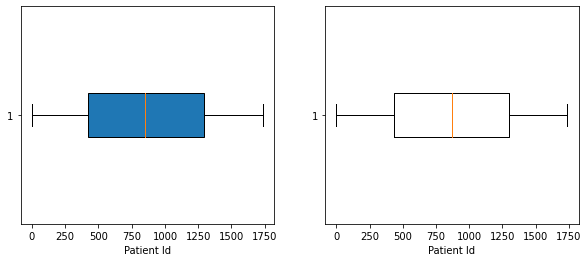

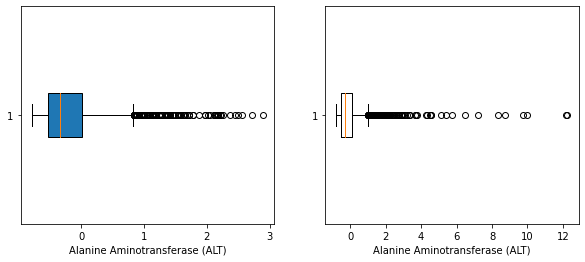

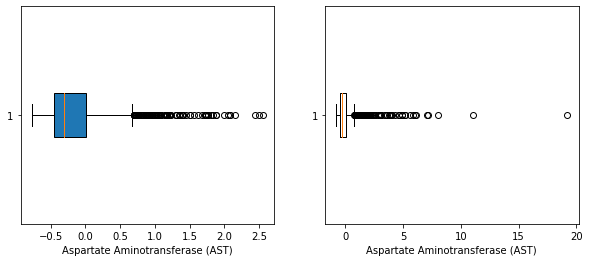

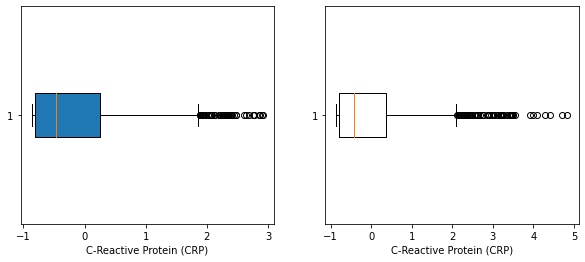

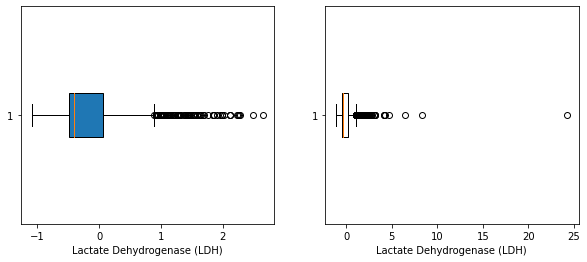

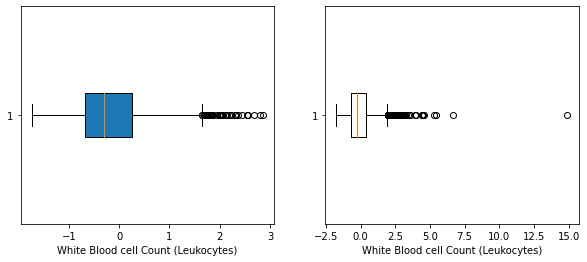

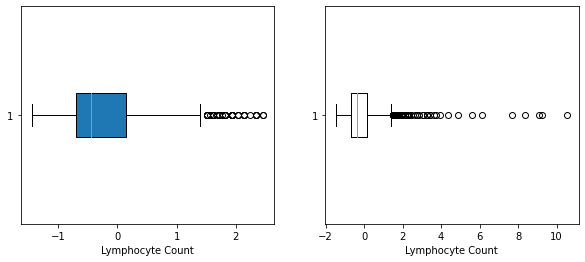

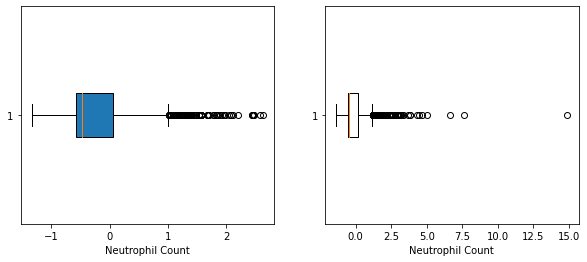

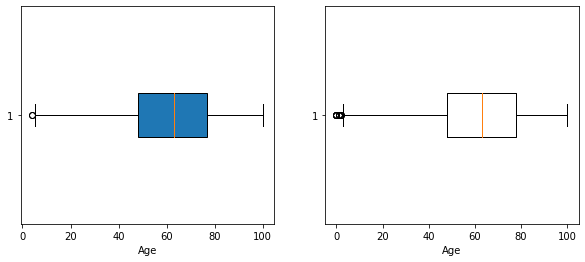

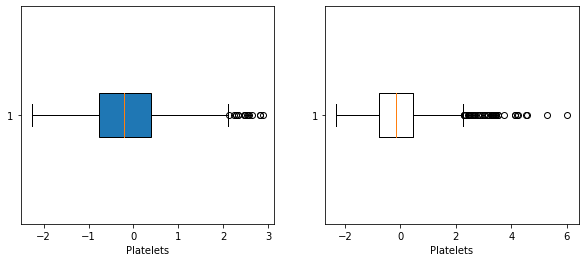

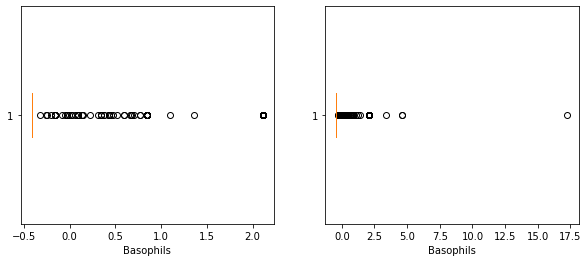

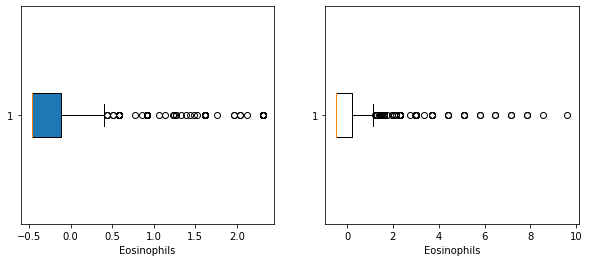

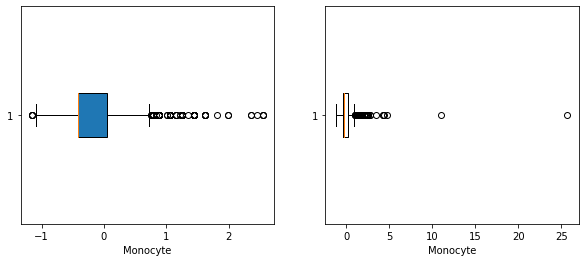

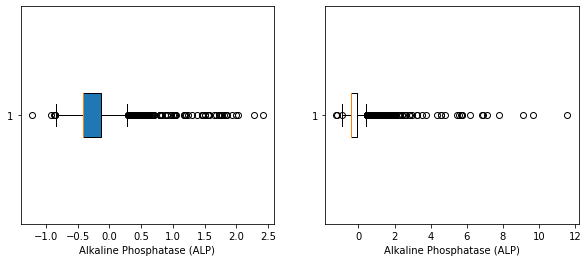

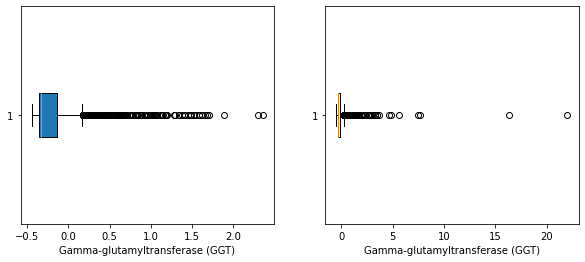

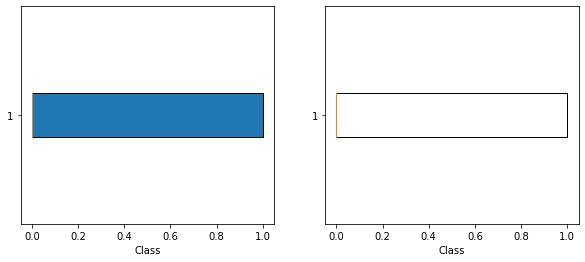

In [ ]:
for col in range(len(new_data.columns)):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].boxplot(new_df[new_data.columns[col]], vert=False, widths=0.2, patch_artist=True)
    axes[1].boxplot(train[new_data.columns[col]], vert=False, widths=0.2)
    axes[0].set_xlabel(new_data.columns[col])
    axes[1].set_xlabel(new_data.columns[col])
    plt.show()

## Part 2: Implementation 

In [ ]:
# Dictionary to store scores
scores = {'Algos':['RFC', 'XGB','LGBM','CatB','VC'], 'Specificity':[], 'Sensitivity':[], 'Precision':[], 'F1':[]}

In [ ]:
X = new_data.drop(['Class'], axis = 1)
y = new_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1388, 15) (348, 15) (1388,) (348,)


In [ ]:
RF_ = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=3, 
                             max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, 
                             min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, 
                             n_jobs=None, oob_score=False, random_state=1, verbose=0, warm_start=False)

XGBOOST_ = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, 
                         gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=12, min_child_weight=1, missing=None, 
                         n_estimators=10, n_jobs=1, nthread=None, objective='binary:logistic', random_state=1, reg_alpha=0, 
                         reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)

LGBM_ = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                       max_depth=5, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, 
                       num_leaves=31, objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0, 
                       subsample_for_bin=200000, subsample_freq=0)

CATB_ = CatBoostClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,random_strength=1)

models = [('RF',RF_),('XGBOOST',XGBOOST_),('LGBM',LGBM_), ('CATBOOST',CATB_)]

In [ ]:
cv = RepeatedKFold(n_splits = 2, n_repeats = 5)

In [ ]:
def score(model):
    if model=="vc":
        clf=VotingClassifier(estimators=models, voting='soft')
    else:
      clf=model

    cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=1)
    
    for train_idx, val_idx in cv.split(X_train,y_train):
        train_X, val_X = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
        clf.fit(train_X, train_y)
    
    specificity = make_scorer(recall_score, pos_label=0)
    spc_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring=specificity)

    sensitivity = make_scorer(recall_score, pos_label=1)
    sns_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring=sensitivity)
    
    prs_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring='precision')

    f1_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring='f1')
    
    return spc_score, sns_score, prs_score, f1_score

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## RandomForest 

In [ ]:
rf_params={
 "max_depth"    : [3, 5, 8, 10, 12, 15],
 "n_estimators" : [5, 10, 20, 50, 100, 150] 
}

In [ ]:
model = RandomForestClassifier(random_state=1)

random_search = RandomizedSearchCV(model, param_distributions=rf_params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  4.213688850402832
Best Params:  {'n_estimators': 100, 'max_depth': 3}


In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)

spc, sns, prs, f1 = score(model_rf)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
99.78 %
Sensitivity (Recall): 
99.75 %
Precision: 
99.76 %
F1-Score: 
99.76 %


## Boosting Algorithms

In [ ]:
params={
 "learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20],
 "max_depth"        : [3, 5, 8, 10, 12, 15],
 "n_estimators"     : [5, 10, 20, 50, 100, 150] 
}

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=1)

In [ ]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  1.0573270320892334
Best Params:  {'n_estimators': 10, 'max_depth': 12, 'learning_rate': 0.01}


In [ ]:
model_xgb = XGBClassifier(n_estimators=10, max_depth=12, learning_rate=0.01, random_state=1)

In [ ]:
spc, sns, f1, prs = score(model_xgb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
99.21 %
Sensitivity (Recall): 
99.75 %
Precision: 
99.47 %
F1-Score: 
99.2 %


### LightGBM

In [ ]:
lgb = LGBMClassifier(random_state=1)

In [ ]:
random_search = RandomizedSearchCV(lgb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

time taken:  1.2535626888275146
Best Params:  {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}


In [ ]:
model_lgb =  LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=1)

In [ ]:
spc, sns, f1, prs = score(model_lgb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
99.09 %
Sensitivity (Recall): 
99.63 %
Precision: 
99.35 %
F1-Score: 
99.09 %


### Catboost

In [ ]:
cb = CatBoostClassifier(random_strength=1)

In [ ]:
random_search = RandomizedSearchCV(cb, param_distributions=params, n_iter=3,scoring='f1',n_jobs=-1,cv=cv, random_state=3)

In [ ]:
start = time.time()
random_search.fit(X_train,y_train)
print("time taken: ", time.time()-start)

print("Best Params: ",random_search.best_params_)

0:	learn: 0.6088401	total: 48.8ms	remaining: 4.83s
1:	learn: 0.5397288	total: 51.7ms	remaining: 2.53s
2:	learn: 0.4833543	total: 54.1ms	remaining: 1.75s
3:	learn: 0.4298725	total: 56.4ms	remaining: 1.35s
4:	learn: 0.3845063	total: 58.8ms	remaining: 1.12s
5:	learn: 0.3455898	total: 61.1ms	remaining: 957ms
6:	learn: 0.3123969	total: 63.5ms	remaining: 843ms
7:	learn: 0.2819820	total: 65.8ms	remaining: 756ms
8:	learn: 0.2553620	total: 68.3ms	remaining: 690ms
9:	learn: 0.2311701	total: 70.5ms	remaining: 635ms
10:	learn: 0.2104105	total: 72.9ms	remaining: 590ms
11:	learn: 0.1904348	total: 75.2ms	remaining: 551ms
12:	learn: 0.1739014	total: 77.6ms	remaining: 519ms
13:	learn: 0.1584050	total: 79.9ms	remaining: 491ms
14:	learn: 0.1443775	total: 82.3ms	remaining: 466ms
15:	learn: 0.1334390	total: 84.7ms	remaining: 445ms
16:	learn: 0.1243752	total: 87.1ms	remaining: 425ms
17:	learn: 0.1155447	total: 89.5ms	remaining: 408ms
18:	learn: 0.1064535	total: 91.9ms	remaining: 392ms
19:	learn: 0.0987747	t

In [ ]:
model_cb =  CatBoostClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)

In [ ]:
spc, sns, f1, prs = score(model_cb)

spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Streaming output truncated to the last 5000 lines.
8:	learn: 0.2798496	total: 18.8ms	remaining: 190ms
9:	learn: 0.2557079	total: 20.9ms	remaining: 188ms
10:	learn: 0.2340444	total: 23ms	remaining: 186ms
11:	learn: 0.2142967	total: 25.1ms	remaining: 184ms
12:	learn: 0.1964135	total: 27.3ms	remaining: 183ms
13:	learn: 0.1806769	total: 29.4ms	remaining: 181ms
14:	learn: 0.1648379	total: 31.6ms	remaining: 179ms
15:	learn: 0.1545935	total: 33.6ms	remaining: 177ms
16:	learn: 0.1456846	total: 35.8ms	remaining: 175ms
17:	learn: 0.1346469	total: 37.8ms	remaining: 172ms
18:	learn: 0.1249711	total: 39.8ms	remaining: 170ms
19:	learn: 0.1169933	total: 41.8ms	remaining: 167ms
20:	learn: 0.1081159	total: 43.9ms	remaining: 165ms
21:	learn: 0.1017884	total: 46.1ms	remaining: 163ms
22:	learn: 0.0942165	total: 48.2ms	remaining: 161ms
23:	learn: 0.0882571	total: 50.2ms	remaining: 159ms
24:	learn: 0.0823168	total: 52.3ms	remaining: 157ms
25:	learn: 0.0788009	total: 54.4ms	remaining: 155ms
26:	learn: 0.0738

###Voting Classifier

In [ ]:
spc, sns, f1, prs = score("vc")

0:	learn: 0.6209982	total: 2.77ms	remaining: 274ms
1:	learn: 0.5560624	total: 5.08ms	remaining: 249ms
2:	learn: 0.5058851	total: 7.36ms	remaining: 238ms
3:	learn: 0.4510873	total: 9.89ms	remaining: 237ms
4:	learn: 0.4080115	total: 12.1ms	remaining: 230ms
5:	learn: 0.3712493	total: 14.2ms	remaining: 222ms
6:	learn: 0.3384391	total: 16.7ms	remaining: 221ms
7:	learn: 0.3067491	total: 18.7ms	remaining: 215ms
8:	learn: 0.2798496	total: 21ms	remaining: 213ms
9:	learn: 0.2557079	total: 23.3ms	remaining: 210ms
10:	learn: 0.2340444	total: 25.3ms	remaining: 204ms
11:	learn: 0.2142967	total: 27.3ms	remaining: 200ms
12:	learn: 0.1964135	total: 29.5ms	remaining: 197ms
13:	learn: 0.1806769	total: 31.6ms	remaining: 194ms
14:	learn: 0.1648379	total: 33.7ms	remaining: 191ms
15:	learn: 0.1545935	total: 35.8ms	remaining: 188ms
16:	learn: 0.1456846	total: 37.9ms	remaining: 185ms
17:	learn: 0.1346469	total: 39.9ms	remaining: 182ms
18:	learn: 0.1249711	total: 42ms	remaining: 179ms
19:	learn: 0.1169933	total

In [ ]:
spc_score = round((np.mean(spc)*100.0), 2)
sns_score = round((np.mean(sns)*100.0),2)
prs_score = round((np.mean(prs)*100.0),2)
f1_score = round((np.mean(f1)*100.0),2)

scores['Specificity'].append(spc_score)
scores['Sensitivity'].append(sns_score)
scores['Precision'].append(prs_score)
scores['F1'].append(f1_score)

print("Specificity: ")
print(spc_score,"%")
print("Sensitivity (Recall): ")
print(sns_score,"%")
print("Precision: ")
print(prs_score,"%")
print("F1-Score: ")
print(f1_score,"%")

Specificity: 
99.32 %
Sensitivity (Recall): 
99.75 %
Precision: 
99.53 %
F1-Score: 
99.31 %


###Graphs

In [ ]:
#Sensitivity
results = pd.DataFrame(scores)
results

,Algos,Specificity,Sensitivity,Precision,F1
0,RFC,99.78,99.75,99.76,99.76
1,XGB,99.21,99.75,99.47,99.20
2,LGBM,99.09,99.63,99.35,99.09
3,CatB,99.09,99.75,99.41,99.09
4,VC,99.32,99.75,99.53,99.31


In [ ]:
resm = results.melt('Algos', var_name='Metrics', value_name='Values')
resm

,Algos,Metrics,Values
0,RFC,Specificity,99.78
1,XGB,Specificity,99.21
2,LGBM,Specificity,99.09
3,CatB,Specificity,99.09
4,VC,Specificity,99.32
5,RFC,Sensitivity,99.75
6,XGB,Sensitivity,99.75
7,LGBM,Sensitivity,99.63
8,CatB,Sensitivity,99.75
9,VC,Sensitivity,99.75


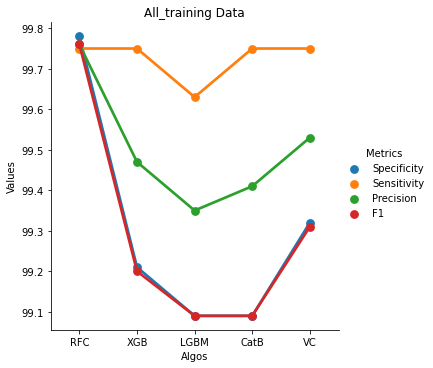

In [ ]:
sns.catplot(x='Algos', y="Values", hue="Metrics", data=resm, kind="point").set(title="All_training Data")